# SOG Freshwater Chemistry Sensitivity Notebook
This is the model sensitivity notebook
### Sections
   1. [Define Local Functions](#Define-Local-Functions)
   2. [Load and Process Data](#Load-and-Process-Data)
   3. [**Make Figures**](#Make-Figures)
       * [Flow Dependence Figures](#Flow-Dependence-Figures)
       * [SOG Timeseries Figures](#SOG-Timeseries-Figures)
       * [SOG Salinity Average Figures](#SOG-Salinity-Average-Figures)
       * [Salinity Space Figures](#Salinity-Space-Figures)

In [10]:
import numpy as np
import cmocean
import os
import SOG_loader
import carbonate
import gsw
import yaml
import matplotlib.pyplot as plt
from salishsea_tools import utilities
from datetime import datetime, timedelta
from matplotlib import cm, patches
from scipy import io, signal
from matplotlib.dates import DateFormatter

%matplotlib inline

In [13]:
plt.rcParams['font.size'] = 12

## Define Local Functions

**`parse_run_path:`** Parses a results path into the year, TA, and DIC:TA keys

In [3]:
def parse_run_path(path, keys):
    """Parses a results path into the year, TA, and DIC:TA keys
    """
    
    params = {}
    string = os.path.split(path)[1]
    params['year'] = string.split('_')[0]
    chemstr = string.split(keys[0], maxsplit=1)[1].split(keys[1])
    params[keys[0]] = chemstr[0]
    params[keys[1]] = chemstr[1]
    
    return params

**`calc_mixing_curve:`** Calculates the linear physical mixing line between freshwater and seawater chemistry endmembers

In [4]:
def calc_mixing_curve(TA, DICTA, S=[0, 30], T=[10, 10], P=[0, 0], PO4=[0, 0], Si=[0, 0], mix_bin=100):
    """Calculates the linear physical mixing line between freshwater and seawater chemistry endmembers
    """
    
    # Create endmembers dict
    DIC = [ta * dicta for ta, dicta in zip(TA, DICTA)]
    endmembers = {'TA': TA, 'DIC': DIC, 'S': S, 'T': T, 'P': P, 'PO4': PO4, 'Si': Si}
    mix = {}
    
    # Generate mixing curves
    for key in endmembers:
        mix[key] = np.arange(mix_bin) / (mix_bin-1) * np.diff(endmembers[key]) + endmembers[key][0]
    
    # pH mixing curves
    CO2 = carbonate.calc_carbonate(
        [mix['TA'], mix['DIC']], mix['PO4'], mix['Si'], mix['T'], mix['S'], mix['P'], params=['TA', 'TC'],
    )
    mix['pH'], mix['OmegaA'], mix['pCO2'] = CO2['pH'], CO2['OmegaA'], CO2['pCO2']
    
    return mix

**`load_SOG_dict:`** Loads SOG timeseries results across freshwater TA runs into a single dictionary

In [5]:
def load_SOG_dict(results, path):
    """Loads SOG timeseries results across freshwater TA runs into a single dictionary
    """
    
    # Parse run path
    params = parse_run_path(path, ['TA', 'DICTA'])
    year, TA, DICTA = params['year'], params['TA'], params['DICTA']
    year = int(year)
    
    # Initialize run dict
    results[DICTA][TA][year] = {}
    
    # Load timeseries
    TS_phys = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_phys_SOG.out'))
    TS_chem = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_chem_SOG.out'))
    TS_bio = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_bio_SOG.out'))
    
    # Extract physics fields
    results[DICTA][TA][year]['t'] = TS_phys['3 m avg temperature']                 # in situ temperature [deg C]
    results[DICTA][TA][year]['SP'] = TS_phys['3 m avg salinity']                   # practical salinity  [PSS 78]
    
    # Calculate and assign TEOS-10 properties
    results[DICTA][TA][year]['SR'] = gsw.conversions.SR_from_SP(results[DICTA][TA][year]['SP'])
    results[DICTA][TA][year]['CT'] = gsw.conversions.CT_from_t(
        results[DICTA][TA][year]['SR'], results[DICTA][TA][year]['t'], 0,
    )
    results[DICTA][TA][year]['rho'] = gsw.density.rho(results[DICTA][TA][year]['SR'], results[DICTA][TA][year]['CT'], 0)
    
    # Extract bio and chem fields
    results[DICTA][TA][year]['NO3'] = TS_bio['3 m avg nitrate concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['NH4'] = TS_bio['3 m avg ammonium concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['Si'] = TS_bio['3 m avg silicon concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['DIC'] = TS_chem['3 m avg DIC concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['TA'] = TS_chem['3 m avg alkalinity'] * 1e3 / results[DICTA][TA][year]['rho']
    
    # Calculate CO2 parameters
    CO2 = carbonate.calc_carbonate(
        [results[DICTA][TA][year]['TA'], results[DICTA][TA][year]['DIC']],         # [TA, DIC]
        (results[DICTA][TA][year]['NO3'] + results[DICTA][TA][year]['NH4']) / 16,  # total phosphate (estimated from N)
        results[DICTA][TA][year]['Si'],                                            # dissolved silica
        results[DICTA][TA][year]['t'],                                             # in situ temperature
        results[DICTA][TA][year]['SP'],                                            # practical salinity
        0,                                                                         # pressure
        params=['TA', 'TC'],
    )
    
    # Assign CO2 parameters
    results[DICTA][TA][year]['pH'] = CO2['pH']                                     # pH [total scale]
    results[DICTA][TA][year]['pCO2'] = CO2['pCO2']                                 # CO2 partial pressure [uatm]
    results[DICTA][TA][year]['OmegaA'] = CO2['OmegaA']                             # aragonite saturation stat
    
    return results

## Load and Process Data

Load SOG timeseries results into dictionary

In [6]:
# Load SOG results
with open('/ocean/bmoorema/research/SOG/SOG-runsets/river_chemistry/run_list.yaml', 'r') as f:
    run_list = yaml.load(f)
SOG_results = {
    '1032': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '1089': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '1226': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
}
bar = utilities.statusbar('Loading ...')
for path in bar(run_list['run_list']):
    SOG_results = load_SOG_dict(SOG_results, path)

Loading ... 100% (216 of 216) |#######################################################################################################################################|Time: 0:09:52


Load Fraser River flow (Q) record into dictionary and calculate dQ/dt

In [7]:
# Load Fraser Record
Fraser = {}
data = io.loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][2].flatten()
Fraser['flow_filter'] = signal.filtfilt(*signal.butter(2, 0.1), Fraser['flow'])
Fraser['dQdt'] = np.diff(Fraser['flow_filter'])/24
Fraser['dQdt'] = np.append(Fraser['dQdt'][0], Fraser['dQdt'])
Fraser['date'] = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in data['fraser'][0][0][1]
]

Create index to bound individual years of flow and sort years by freshet size

In [19]:
# Sort years by freshet
index_flow = {}
freshet = []
for year in range(2001, 2017):
    index_flow[year] = [
        abs(np.array(Fraser['date']) - datetime(year, 1, 1) - timedelta(days=yearday)).argmin()
        for yearday in [0, 365]
    ]
    freshet.append(Fraser['flow_filter'][slice(*index_flow[year])].max())
    #freshet.append(Fraser['flow'][slice(*index_flow[year])].sum())
years = np.arange(2001, 2017)[np.array(freshet).argsort()]

Define lists of TA and DIC:TA scenarios for iteration

In [8]:
TAs = ['250', '500', '750', '1000', '1250']
DICTAs = ['1032', '1089', '1226']

Define plotting properties for each year into a master dictionary `plot_props`

In [22]:
# Plotting properties
plot_props = {}
for index, year in enumerate(years):
    plot_props[year] = {'bgcolor': None, 'edgecolor': None, 'marker': 'o', 'size': 6, 'width': 1.5, 'zorder': 0}
    plot_props[year]['color'] = cm.get_cmap(cmocean.cm.haline)(index/11)
plot_props[2016] = {'color': 'r', 'bgcolor': 'pink', 'edgecolor': 'k', 'marker': '*', 'size': 16, 'width': 2, 'zorder': 10}
#plot_props[2012] = {'color': 'k', 'bgcolor': 'darkgray', 'edgecolor': 'k', 'marker': '*', 'size': 16, 'width': 2, 'zorder': 10}

## Make Figures

### Flow Dependence Figures

These figures are designed to show the seasonality and interannual variability of Fraser River flow, and the sensitivity of the model to flow-dependent changes in freshwater TA. All model results are comparisons between the flow dependent (dQ/dt) and constant (750 umol/kg) TA$_f$ cases at (DIC:TA)$_f$ = 1.089 (middle case)
   1. Fraser River hydrograph at Hope
   2. Flow dependent freshwater TA (TA$_f$) based on dQ/dt
   3. $\Delta$pH
   4. $\Delta\Omega_A$

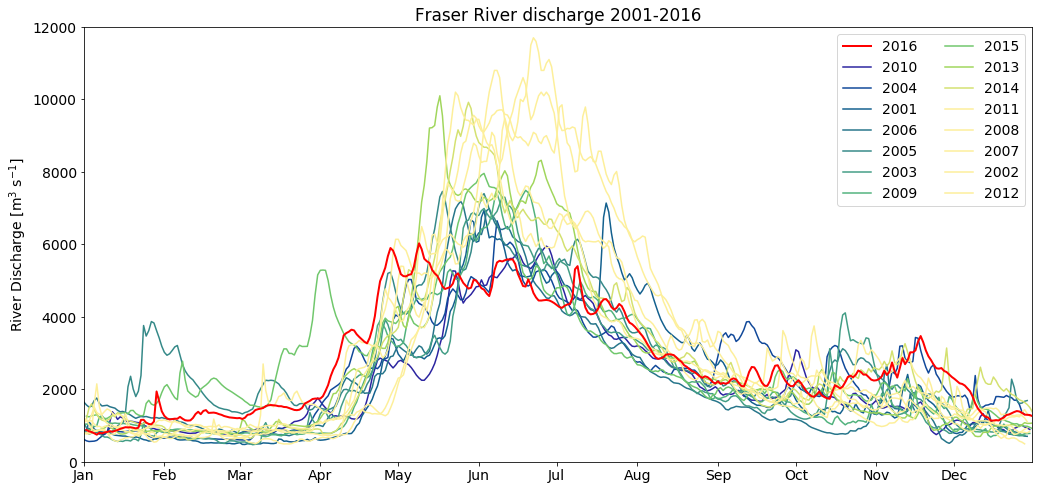

In [30]:
# Make figure axes
fig, axs = plt.subplots(1, 1, figsize=(17, 8))

# Plot formatters
ylims = [[0, 12000], [5, 32]]
ylabels = [
    'River Discharge [m$^{3}$ s$^{-1}$]',
    'Salinity',
]

# Loop through years
for year in years:
    date = (np.array(Fraser['date'])[slice(*index_flow[year])] - timedelta(days=(int(year) - 2012)*365))
    #axs[0].plot(
    #    date, Fraser['flow'][slice(*index_flow[year])], '--', color='lightgrey',
    #    linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    #)
    axs.plot(
        date, Fraser['flow'][slice(*index_flow[year])], '-', color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'], label=f'{year:d}',
    )
    #date = (
    #    SOG_results['1089']['750'][year]['SP'].date.values.astype('datetime64[s]').astype(datetime) -
    #    timedelta(days=(int(year) - 2012)*365)
    #)
    #axs[1].plot(
    #    date, SOG_results['1089']['750'][year]['SP'],
    #    color=plot_props[year]['color'], linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    #)

# Format plots
for ax, ylim, ylabel, label in zip([axs], ylims, ylabels, ['(a) Fraser River discharge at Hope', '(b) Model 3 m avg salinity']):
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    #ax.text(0.01, 0.94, label, transform=ax.transAxes)

axs.legend(loc=1, ncol=2)
axs.set_title('Fraser River discharge 2001-2016') # and model salinity')
plt.show()
fig.savefig('/home/bmoorema/Desktop/FraserDischargeDebby.pdf', dpi=300, bbox_inches='tight')

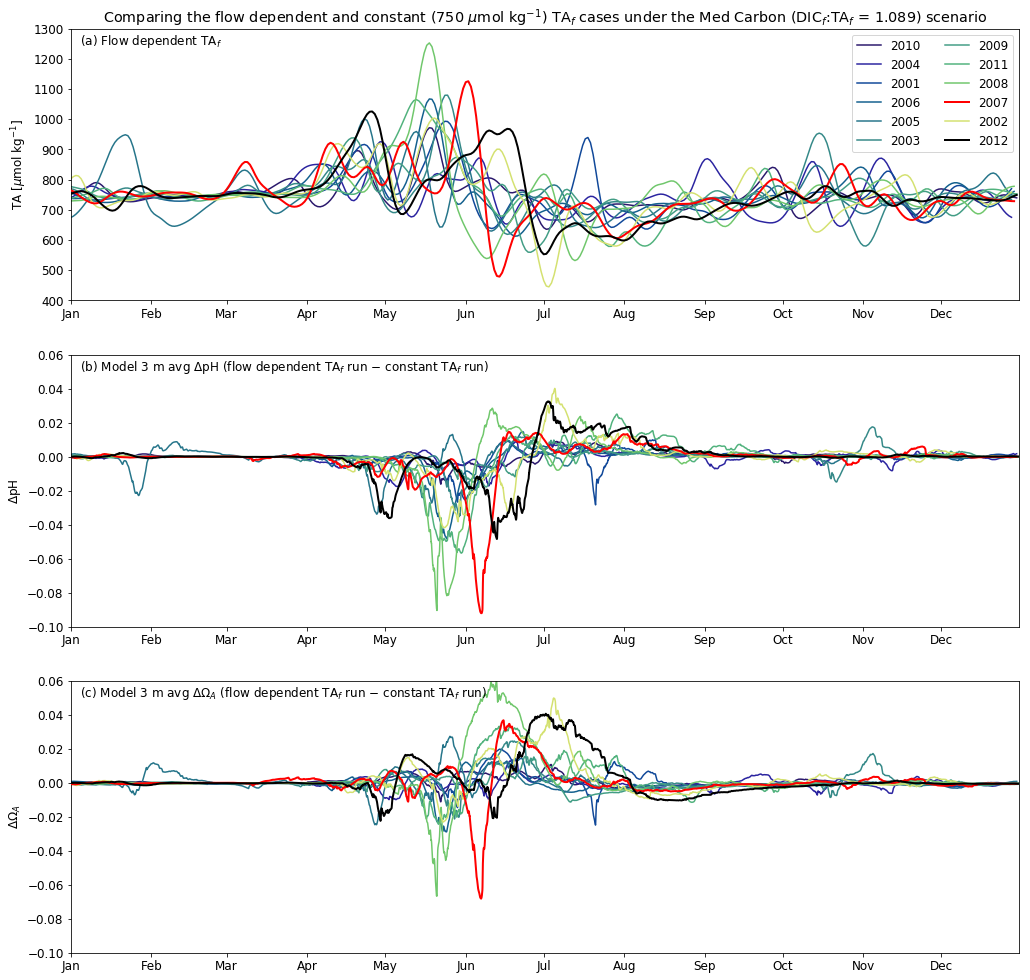

In [487]:
# Make figure axes
fig, axs = plt.subplots(3, 1, figsize=(17, 17))

# Plot formatters
ylims = [[400, 1300], [-0.1, 0.06], [-0.1, 0.06]]
ylabels = [
    'TA [$\mu$mol kg$^{-1}$]',
    '$\Delta$pH',
    '$\Delta\Omega_A$',
]
figlabels = [
    '(a) Flow dependent TA$_f$',
    '(b) Model 3 m avg $\Delta$pH (flow dependent TA$_f$ run $-$ constant TA$_f$ run)',
    '(c) Model 3 m avg $\Delta\Omega_A$ (flow dependent TA$_f$ run $-$ constant TA$_f$ run)',
]

# Loop through years
for year in years:
    date = (np.array(Fraser['date'])[slice(*index_flow[year])] - timedelta(days=(int(year) - 2012)*365))
    axs[0].plot(
        date, 22.1*Fraser['dQdt'][slice(*index_flow[year])] + 750, '-', color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'], label=f'{year:d}',
    )
    date = (
        SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
        timedelta(days=(int(year) - 2012)*365)
    )
    axs[1].plot(
        date, SOG_results['1089']['var'][year]['pH'] - SOG_results['1089']['750'][year]['pH'],
        color=plot_props[year]['color'], linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )
    axs[2].plot(
        date, SOG_results['1089']['var'][year]['OmegaA'] - SOG_results['1089']['750'][year]['OmegaA'],
        color=plot_props[year]['color'], linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )

# Format plots
for ax, ylim, ylabel, label in zip(axs, ylims, ylabels, figlabels):
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.text(0.01, 0.94, label, transform=ax.transAxes)

axs[0].legend(loc=1, ncol=2)
axs[0].set_title('Comparing the flow dependent and constant (750 $\mu$mol kg$^{-1}$) TA$_f$ cases under the Med Carbon (DIC$_f$:TA$_f$ = 1.089) scenario')
plt.show()
fig.savefig('/home/bmoorema/Desktop/NewRiverFigs/FlowDependence.pdf', dpi=300, bbox_inches='tight')

### SOG Timeseries Figures

These figures are designed to both communicate the actual cycles of model chemistry variables throughout the year, and the dramatic difference between low (2010) and high (2012) flow years. All timeseries plotted are 3 m averages for 2010 and 2012 only at (DIC:TA)$_f$ = 1.089
   1. DIC:TA
   2. pH
   3. $\Omega_A$

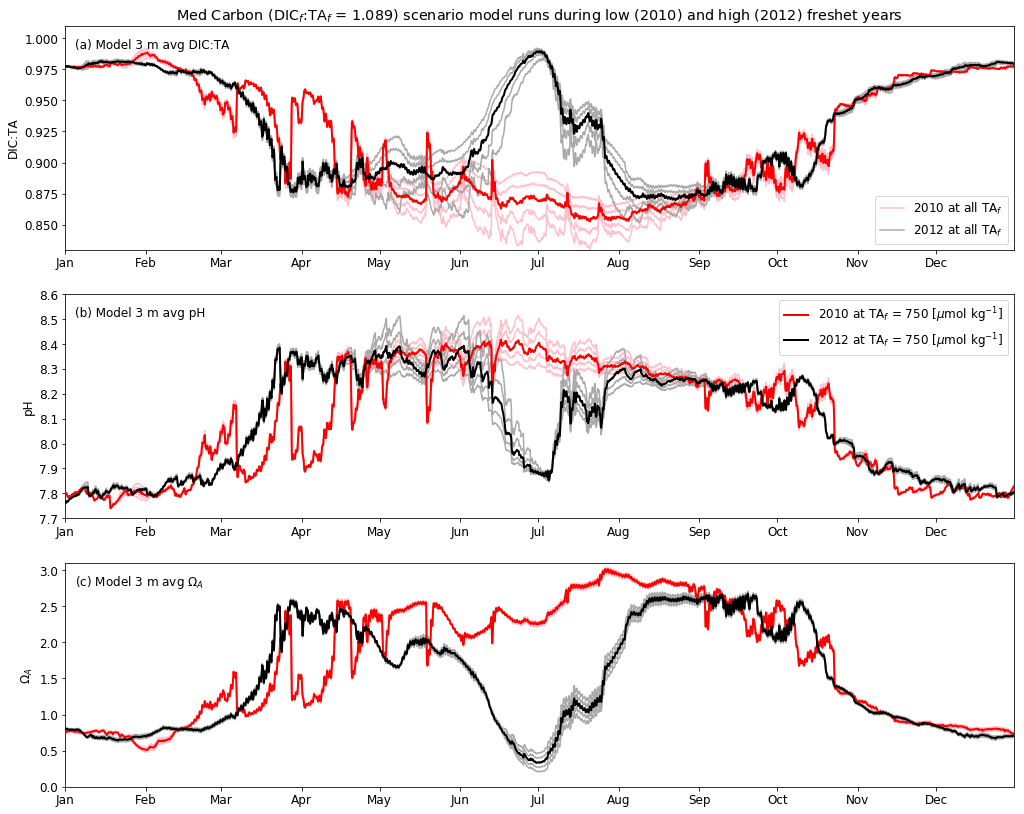

In [469]:
# Make figure axes
fig, axs = plt.subplots(3, 1, figsize=(17, 14))
ylims = [[0.83, 1.01], [7.7, 8.6], [0, 3.1]]
figlabels = [
    '(a) Model 3 m avg DIC:TA',
    '(b) Model 3 m avg pH',
    '(c) Model 3 m avg $\Omega_A$',
]

for year in [2010, 2012]:
    date = (
        SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
        timedelta(days=(int(year) - 2012)*365)
    )
    for TA in TAs:
        label = None
        if TA == '750':
            label = f'{year} at all TA$_f$'
        axs[0].plot(
            date, SOG_results['1089'][TA][year]['DIC'] / SOG_results['1089'][TA][year]['TA'],
            color=plot_props[year]['bgcolor'], label=label,
        )
        axs[1].plot(date, SOG_results['1089'][TA][year]['pH'], color=plot_props[year]['bgcolor'])
        axs[2].plot(date, SOG_results['1089'][TA][year]['OmegaA'], color=plot_props[year]['bgcolor'])
    
    label=f'{year} at TA$_f$ = 750 [$\mu$mol kg$^{{-1}}$]'
    axs[0].plot(
            date, SOG_results['1089']['750'][year]['DIC'] /
            SOG_results['1089']['750'][year]['TA'],
            color=plot_props[year]['color'], linewidth=plot_props[year]['width'],
            zorder=plot_props[year]['zorder'],
    )
    axs[1].plot(
        date, SOG_results['1089']['750'][year]['pH'], color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'], label=label,
    )
    axs[2].plot(
        date, SOG_results['1089']['750'][year]['OmegaA'], color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )

for ax, ylim, label, figlabel in zip(axs, ylims, ['DIC:TA', 'pH', '$\Omega_A$'], figlabels):
    ax.set_ylim(ylim)
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    ax.set_ylabel(label)
    ax.text(0.01, 0.9, figlabel, transform=ax.transAxes)

axs[0].legend(loc=4)
axs[1].legend(loc=1)
axs[0].set_title('Med Carbon (DIC$_f$:TA$_f$ = 1.089) scenario model runs during low (2010) and high (2012) freshet years')
plt.show()
fig.savefig('/home/bmoorema/Desktop/NewRiverFigs/Timeseries.pdf', dpi=300, bbox_inches='tight')

### SOG Salinity Average Figures

These figures are designed compress the SOG results using a salinity average to show the overall effect of varying freshwater TA and DICTA on the model variables. The columns vary (DIC:TA)$_f$ and the rows show the following model results. Colors are the same as in the flow dependence figures.
   1. DIC:TA
   2. pH
   3. $\Omega_A$

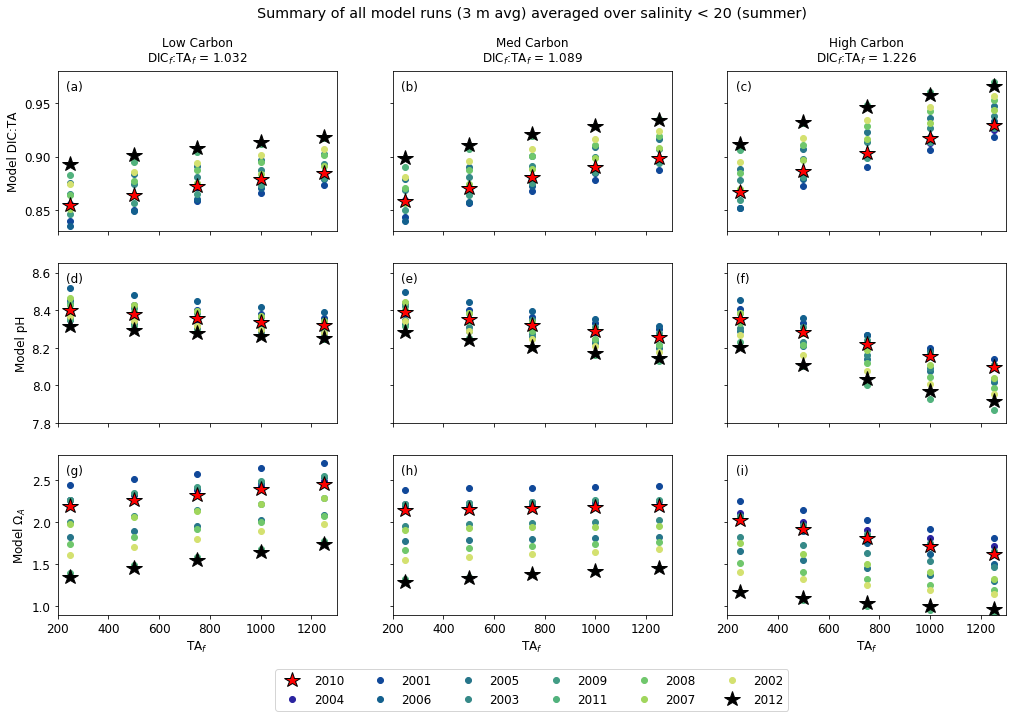

In [473]:
# Make figure axes
fig, axs = plt.subplots(3, 3, figsize=(17, 10))

params = ['DICTA', 'pH', 'OmegaA']
ylims = [[0.83, 0.98], [7.8, 8.65], [0.9, 2.8]]
ylabels = ['Model DIC:TA', 'Model pH', 'Model $\Omega_A$']
plotlabels = [
    ['(a)', '(b)', '(c)'],
    ['(d)', '(e)', '(f)'],
    ['(g)', '(h)', '(i)'],
]

# Loop through plots
for row, param, lim, label, plotrow in zip(axs, params, ylims, ylabels, plotlabels):
    for ax, DICTA, plotlabel, C_case in zip(row, DICTAs, plotrow, ['Low', 'Med', 'High']):
        
        # Deal with axis lims, ticks, and labels
        ax.set_ylim(lim)
        ax.text(0.03, 0.88, plotlabel, transform=ax.transAxes)
        if param is 'DICTA':
            ax.text(0.5, 1.05, f'{C_case} Carbon\nDIC$_f$:TA$_f$ = {int(DICTA)*1e-3:.3f}', transform=ax.transAxes, ha='center')
        if param is not 'OmegaA':
            ax.xaxis.set_ticklabels('')
        else:
            ax.set_xlabel('TA$_f$')
        if DICTA is not '1032':
            ax.yaxis.set_ticklabels('')
        else:
            ax.set_ylabel(label)
        
        # Loop throught TA scenarios
        for TA in TAs:
            for year in years:
                label = None
                if TA is '750':
                    label = str(year)
                index_sal = SOG_results[DICTA][TA][year]['SP'] < 20
                if param is 'pH':
                    val = SOG_results[DICTA][TA][year]['pH'][index_sal].mean()
                elif param is 'OmegaA':
                    val = SOG_results[DICTA][TA][year]['OmegaA'][index_sal].mean()
                elif param is 'DICTA':
                    val = (
                        SOG_results[DICTA][TA][year]['DIC'][index_sal] / 
                        SOG_results[DICTA][TA][year]['TA'][index_sal]
                    ).mean()
                ax.plot(
                    int(TA), val, marker=plot_props[year]['marker'], color=plot_props[year]['color'],
                    markeredgecolor=plot_props[year]['edgecolor'],  markersize=plot_props[year]['size'],
                    zorder=plot_props[year]['zorder'], linestyle='', label=label,
                )
axs[2, 1].legend(ncol=6, loc=(-0.42, -0.6))
axs[0, 1].set_title('Summary of all model runs (3 m avg) averaged over salinity < 20 (summer)', y=1.3)
plt.show()
fig.savefig('/home/bmoorema/Desktop/NewRiverFigs/SalinityAverages.pdf', dpi=300, bbox_inches='tight')

### Salinity Space Figures

These figures are designed to demonstrate how the SOG model results differ from the theoretical two-endmember mixing curves. The following endmember cases plotted are shown:
   * (DIC:TA)$_f$ = 1.032 (blue)
   * (DIC:TA)$_f$ = 1.090 (black)
   * (DIC:TA)$_f$ = 1.226 (red)
   * TA$_f$ = 500 umol/kg (solid)
   * TA$_f$ = 1000 umol/kg (dashed line or open symbol)
   
The three subplots show the following estuarine chemical variables:
   1. DIC:TA
   2. pH
   3. $\Omega_A$

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:58: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(date="D").mean('date') 
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:59: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(date="D").mean('date') 
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:64: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(date="D").mean('date') 
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:68: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(date="D").mean('date') 
/home/bmoorema/a

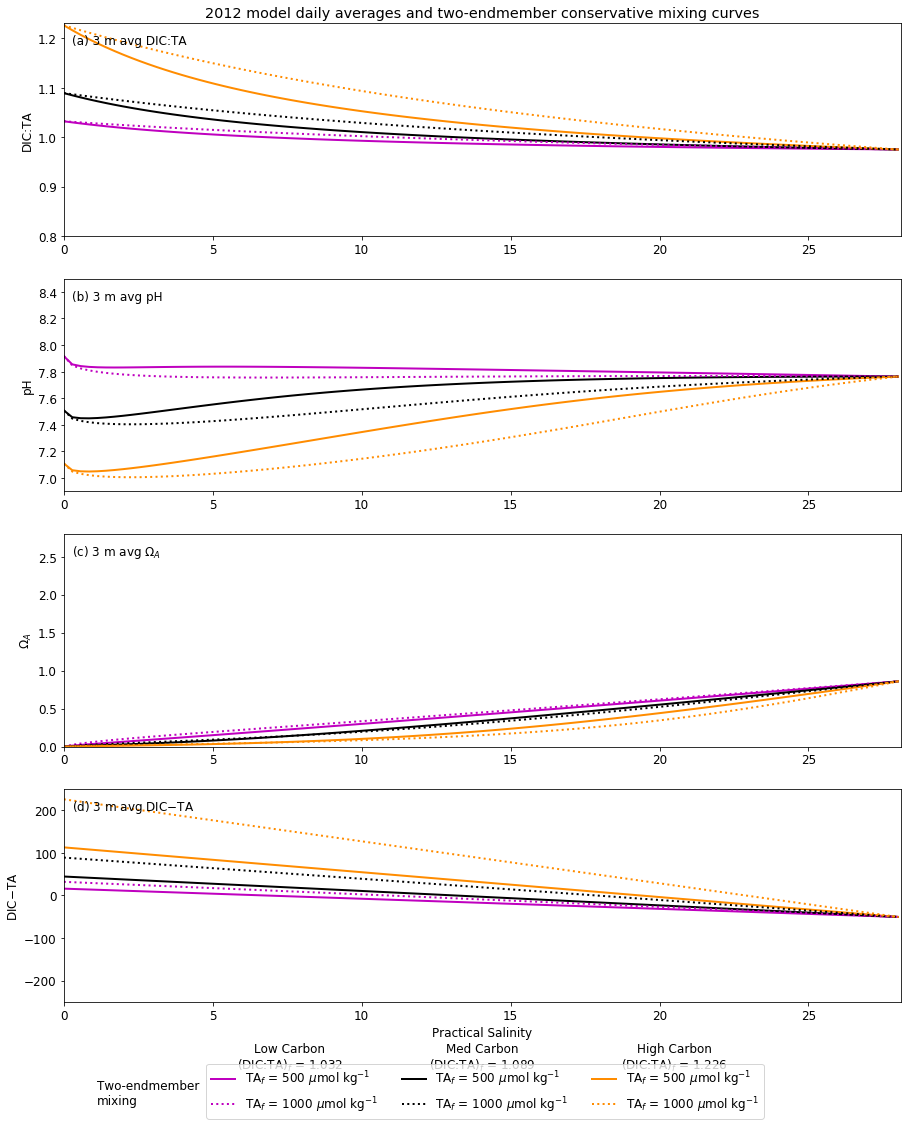

In [26]:
# Make figure axes
fig, axs = plt.subplots(4, 1, figsize=(15, 18))

# Plot parameters
year = 2012
params = ['DICTA', 'pH', 'OmegaA', 'DICminusTA']
ylims = [[0.8, 1.23], [6.9, 8.5], [0, 2.8], [-250, 250]]
ylabels = ['DIC:TA', 'pH', '$\Omega_A$', 'DIC$-$TA', ]
plotlabels = ['(a) 3 m avg DIC:TA', '(b) 3 m avg pH', '(c) 3 m avg $\Omega_A$', '(d) 3 m avg DIC$-$TA']
axs[3].set_xlabel('Practical Salinity')
axs[0].set_title('2012 model daily averages and two-endmember conservative mixing curves')

for ax, ylim, ylabel, plotlabel in zip(axs, ylims, ylabels, plotlabels):
    ax.set_xlim([0, 28.1])
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.text(0.01, 0.9, plotlabel, transform=ax.transAxes)

# Seawater endmembers
endmember_sea = {'TA': 2020, 'DICTA': 0.975, 'T': 9, 'S': 28, 'P': 0, 'PO4': 2, 'Si': 50}

tindex = [
    abs(SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
    datetime(year, month, 1)).argmin() for month in [1, 7]
]
# ['magenta', 'k', 'darkorange'], ['orchid', 'dimgray', 'orange']
# Loop through TA and DICTA endmembers

DICTA_colors = ['m', 'k', 'darkorange']
for TA, linestyle, fillstyle in zip(['500', '1000'], ['-', ':'], ['full', 'none']):
    for DICTA, color, linewidth, marker in zip(DICTAs, DICTA_colors, [2, 2, 2], [8, 8, 8]):
        
        # Calculate two endmember mixing curves
        mix = calc_mixing_curve(
            [int(TA), endmember_sea['TA']], [int(DICTA)*1e-3, endmember_sea['DICTA']],
            S=[0, endmember_sea['S']], T=[10, endmember_sea['T']], PO4=[0, endmember_sea['PO4']],
            Si=[0, endmember_sea['Si']],
        )
        
        # Loop through subplots
        for ax, param in zip(axs, params):
            
            # Set plot label
            #label = None
            #if DICTA is '1226':
            label = f'TA$_f$ = {TA} $\mu$mol kg$^{{-1}}$'
            
            # Plot mixing curves
            if param is 'DICTA':
                y = mix['DIC']/mix['TA']
            elif param is 'DICminusTA':
                y = mix['DIC']-mix['TA']
            else:
                y = mix[param]
            ax.plot(mix['S'], y, '-', color=color, linestyle=linestyle, linewidth=linewidth, label=label)
            
            # Plot model results
            x_list = SOG_results[DICTA][TA][year]['SP'][slice(*tindex)].resample('D', 'date')
            x_bg = SOG_results[DICTA][TA][year]['SP'][tindex[1]:].resample('D', 'date')
            if param is 'DICTA':
                y_list = (
                    SOG_results[DICTA][TA][year]['DIC'] /
                    SOG_results[DICTA][TA][year]['TA']
                )[slice(*tindex)].resample('D', 'date')
                y_bg = (
                    SOG_results[DICTA][TA][year]['DIC'] /
                    SOG_results[DICTA][TA][year]['TA']
                )[tindex[1]:].resample('D', 'date')
            elif param is 'DICminusTA':
                y_list = (
                    SOG_results[DICTA][TA][year]['DIC'] -
                    SOG_results[DICTA][TA][year]['TA']
                )[slice(*tindex)].resample('D', 'date')
                y_bg = (
                    SOG_results[DICTA][TA][year]['DIC'] -
                    SOG_results[DICTA][TA][year]['TA']
                )[tindex[1]:].resample('D', 'date')
            else:
                y_list = SOG_results[DICTA][TA][year][param][slice(*tindex)].resample('D', 'date')
                y_bg = SOG_results[DICTA][TA][year][param][tindex[1]:].resample('D', 'date')
            #label = None
            #if DICTA is '1226':
            label=f'TA$_f$ = {TA} $\mu$mol kg$^{{-1}}$'
            #ax.plot(x_list, y_list, 'o', markersize=marker, linestyle='', color=color, fillstyle=fillstyle, label=label, zorder=10)
            

# Reorder handles and make legend
h, l = ax.get_legend_handles_labels()
handles = [h[0], h[3], h[1], h[4], h[2], h[5]] #[h[0], h[6], h[1], h[7], h[2], h[8], h[3], h[9], h[4], h[10], h[5], h[11]]
labels = [l[0], l[3], l[1], l[4], l[2], l[5]] #[l[0], l[6], l[1], l[7], l[2], l[8], l[3], l[9], l[4], l[10], l[5], l[11]]
axs[3].legend(handles, labels, ncol=3, loc=(0.17, -0.55)) #-0.74))
axs[3].text(0.04, -0.48, 'Two-endmember\nmixing', transform=axs[3].transAxes)
#axs[3].text(0.04, -0.72, 'Biogeochemical\nmodel', transform=axs[3].transAxes)
DICTA_labels = [
    'Low Carbon\n(DIC:TA)$_f$ = 1.032',
    'Med Carbon\n(DIC:TA)$_f$ = 1.089',
    'High Carbon\n(DIC:TA)$_f$ = 1.226',
]
for xpos, DICTA_label in zip([0.27, 0.5, 0.73], DICTA_labels):
    axs[3].text(xpos, -0.32, DICTA_label, transform=axs[3].transAxes, ha='center')

# Cartoon
cartoon = False
if cartoon:
    axs[0].arrow(0.98, 0.32, 0, -0.2, color='g', head_width=0.01, head_length=0.03, transform=axs[0].transAxes)
    axs[0].arrow(0.99, 0.09, 0, 0.2, color='dodgerblue', head_width=0.01, head_length=0.03, transform=axs[0].transAxes)
    axs[0].arrow(0.95, 0.09, -0.45, 0, color='g', width=0.003, head_width=0.04, head_length=0.01, transform=axs[0].transAxes)
    axs[0].arrow(0.49, 0.05, 0.45, 0, color='dodgerblue', width=0.003, head_width=0.04, head_length=0.01, transform=axs[0].transAxes)
    axs[0].arrow(12.8, 0.84, -7.4, 0.09, color='g', head_width=0.02, head_length=0.3)
    axs[0].arrow(5.2, 0.915, 7.4, -0.09, color='dodgerblue', head_width=0.02, head_length=0.3)
    axs[0].annotate(
        'Fall/Winter/Spring', xy=(0.91, 0.88), xytext=(0.91, 0.93), xycoords='axes fraction', 
        ha='center', va='bottom', transform=axs[0].transAxes,
        arrowprops=dict(arrowstyle='-[, widthB=5.5, lengthB=1.5', lw=2.0),
    )
    axs[0].annotate(
        'Summer', xy=(0.65, 0.88), xytext=(0.65, 0.93), xycoords='axes fraction', 
        ha='center', va='bottom', transform=axs[0].transAxes,
        arrowprops=dict(arrowstyle='-[, widthB=11, lengthB=1.5', lw=2.0),
    )
    axs[0].annotate(
        'Freshet', xy=(0.33, 0.88), xytext=(0.33, 0.93), xycoords='axes fraction', 
        ha='center', va='bottom', transform=axs[0].transAxes,
        arrowprops=dict(arrowstyle='-[, widthB=10, lengthB=1.5', lw=2.0),
    )
    axs[0].text(0.91, 0.48, 'Winter', transform=axs[0].transAxes)
    axs[0].text(1.005, 0.25, 'Fall bloom\ntermination', color='dodgerblue', transform=axs[0].transAxes)
    axs[0].text(1.005, 0.05, 'Spring\nbloom', color='g', transform=axs[0].transAxes)
    axs[0].text(0.6, 0.08, 'Late spring productivity', color='g', transform=axs[0].transAxes, bbox=dict(facecolor='w', edgecolor='none', pad=1))
    axs[0].text(0.8, 0.03, 'Fall blooms', color='dodgerblue', transform=axs[0].transAxes, bbox=dict(facecolor='w', edgecolor='none', pad=1))
    axs[0].text(0.12, 0.29, 'Freshet', color='g', transform=axs[0].transAxes)
    axs[0].text(0.23, 0.04, 'Late summer\nproductivity', color='dodgerblue', transform=axs[0].transAxes)

plt.show()
fig.savefig('/home/bmoorema/Desktop/SalinitySpace_nomodel.pdf', dpi=300, bbox_inches='tight')

In [23]:
import xarray as xr

In [120]:
def set_ds_attrs():
    """
    """
    
    ta_val = f'{ta} umol/kg'
    if ta is 'var':
        ta_val = 'flow-dependent'
    
    ds.attrs['acknowledgement'] = 'MEOPAR, Fisheries and Oceans Canada'
    ds.attrs['creator_email'] = 'bmoorema@eoas.ubc.ca'
    ds.attrs['creator_name'] = 'Ben Moore-Maley'
    ds.attrs['creator_url'] = 'https://salishsea-meopar-docs.readthedocs.io/'
    ds.attrs['description'] = f'ocean tracer variables at {ta_val} river TA and {int(dicta)/1000} river DIC:TA ratio'
    ds.attrs['institution'] = 'UBC EOAS'
    ds.attrs['institution_fullname'] = 'Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    ds.attrs['keywords'] = 'temperature, salinity, nitrate, ammonium, silica, dissolved inorganic carbon, total alkalinity, pH, pCO2, aragonite, carbonate, ocean, acidification'
    ds.attrs['license'] = 'The SOG biogeochemical model results are copyright by the Salish Sea MEOPAR Project Contributors and The University of British Columbia. They are licensed under the Creative Commons Attribution 4.0 International License https://creativecommons.org/licenses/by/4.0.'
    ds.attrs['project'] = 'The SOG biogeochemical model of the Strait of Georgia'
    ds.attrs['summary'] = f'3 m avg, 900 second tracer outputs of the SOG biogeochemical model of the Strait of Georgia required to constrain the carbonate equilibria. These particular data use a {ta_val} river TA and a river DIC:TA ratio of {int(dicta)/1000}'
    ds.attrs['time_coverage_end'] = '2012-12-31T23:57:20PST'
    ds.attrs['time_coverage_start'] = '2001-01-01T00:12:32PST'
    ds.attrs['timeStamp'] = '2018-Jan-26 16:26:33 PST'
    ds.attrs['title'] = '3 m avg, 900 second tracer outputs of the SOG biogeochemical model of the Strait of Georgia required to constrain the carbonate equilibria'

In [133]:
YEAR = range(2001, 2013)
TA = ['250', '500', '750', '1000', '1250', 'var']
DICTA = ['1032', '1089', '1226']
ATTR = {
    't': {'units': 'deg C'},
    'SP': {'units': 'PSU'},
    'NO3': {'units': 'umol kg-1'},
    'NH4': {'units': 'umol kg-1'},
    'Si': {'units': 'umol kg-1'},
    'DIC': {'units': 'umol kg-1'},
    'TA': {'units': 'umol kg-1'},
}
savepath = '/ocean/bmoorema/research/SOG/Results/river_chemistry_netCDF'

for dicta in DICTA:
    for ta in TA:
        dataarrays = []
        for attr in ATTR.items():
            timeseries = []
            for year in YEAR:
                timeseries.append(
                    SOG_results[dicta][ta][year][attr[0]].sel(date=slice(datetime(year, 1, 1), datetime(year+1, 1, 1)))
                )
            dataarray = xr.concat(timeseries, dim='date')
            dataarray.attrs['units'] = attr[1]['units']
            dataarrays.append(dataarray)
        ds = xr.merge(dataarrays)
        set_ds_attrs()
        ds.to_netcdf(os.path.join(savepath, f'SOG_TA{ta}DICTA{dicta}.nc'))